In [1]:
import hopsworks
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from matplotlib import pyplot
from hsml.schema import Schema
from hsml.model_schema import ModelSchema
import joblib
import os

In [2]:
import os
 
for k, v in os.environ.items():
    if "HOPS" in k:
        print(f'{k}={v}')

HOPSWORKS_API_KEY=YKloWFapPUWBLCPR.uhZrk6x2nayz4rY8qQRuMVftVqNJJW7KPfPMLXd78IzxyWHXe1wVC3pIBR8SrQha


In [3]:
# You have to set the environment variable 'HOPSWORKS_API_KEY' for login to succeed
project = hopsworks.login()
fs = project.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/187540
Connected. Call `.close()` to terminate connection gracefully.


In [4]:
# The feature view is the input set of features for your model. The features can come from different feature groups.    
# You can select features from different feature groups and join them together to create a feature view
wine_fg = fs.get_feature_group(name="wine", version=1)
query = wine_fg.select_all()
feature_view = fs.get_or_create_feature_view(name="wine",
                                  version=1,
                                  description="Read from wine quality dataset",
                                  labels=["quality"],
                                  query=query)

In [5]:
# You can read training data, randomly split into train/test sets of features (X) and labels (y)        
X_train, X_test, y_train, y_test = feature_view.train_test_split(0.2)

# Train our model with the Scikit-learn Random Forest  using our features (X_train) and labels (y_train)
model = RandomForestClassifier(n_estimators=25, criterion='gini')
model.fit(X_train, y_train.values.ravel())

Finished: Reading data from Hopsworks, using ArrowFlight (1.18s) 


RandomForestClassifier(n_estimators=25)

In [6]:
X_train.columns.to_list()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'density',
 'alcohol',
 'type_white']

In [7]:
X_test.columns.to_list()

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'chlorides',
 'density',
 'alcohol',
 'type_white']

In [8]:
# Evaluate model performance using the features from the test set (X_test)
y_pred = model.predict(X_test)

# Compare predictions (y_pred) with the labels in the test set (y_test)
metrics = classification_report(y_test, y_pred, output_dict=True)
results = confusion_matrix(y_test, y_pred)

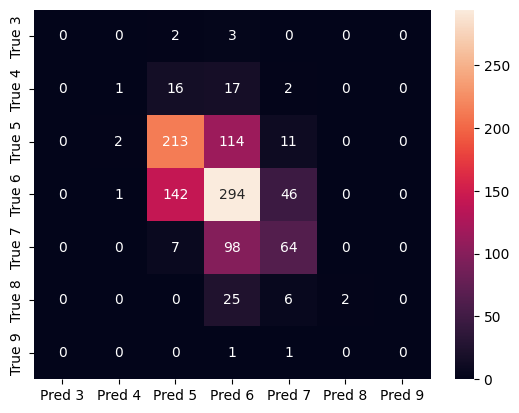

In [9]:
# Create the confusion matrix as a figure, we will later store it as a PNG image file
true_labels = [f'True {int(i)}' for i in range(3,10)]
pred_labels = [f'Pred {int(i)}' for i in range(3,10)]
df_cm = pd.DataFrame(results, true_labels, pred_labels)
cm = sns.heatmap(df_cm, annot=True, fmt='g')
fig = cm.get_figure()

In [10]:
# We will now upload our model to the Hopsworks Model Registry. First get an object for the model registry.
mr = project.get_model_registry()

# The contents of the 'wine_model' directory will be saved to the model registry. Create the dir, first.
model_dir="wine_model"
if os.path.isdir(model_dir) == False:
    os.mkdir(model_dir)

# Save both our model and the confusion matrix to 'model_dir', whose contents will be uploaded to the model registry
joblib.dump(model, model_dir + "/wine_model.pkl")
fig.savefig(model_dir + "/confusion_matrix.png")    

# Specify the schema of the model's input/output using the features (X_train) and labels (y_train)
input_schema = Schema(X_train)
output_schema = Schema(y_train)
model_schema = ModelSchema(input_schema, output_schema)

# Create an entry in the model registry that includes the model's name, desc, metrics
wine_model = mr.python.create_model(
    name="wine_model", 
    metrics={"accuracy" : metrics['accuracy']},
    model_schema=model_schema,
    description="Wine Quality Predictor"
)

# Upload the model to the model registry, including all files in 'model_dir'
wine_model.save(model_dir)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Model created, explore it at https://c.app.hopsworks.ai:443/p/187540/models/wine_model/2


Model(name: 'wine_model', version: 2)